## Update a wflow model: water demand

With HydroMT, you can easily read your model and update one or several components of your model using the **update** function of the command line interface (CLI). Here are the steps and some examples on how to **add water demand information** to your wflow_sbm model.

All lines in this notebook which starts with ! are executed from the command line. Within the notebook environment the logging messages are shown after completion. You can also copy these lines and paste them in your shell to get more feedback.

You can update a wflow_sbm model to include the simulation of water demand and allocation. This can be important in basins where there is substantial human influence, and/or you might want to simulate what will happen if (more) water is consumed. We identify four different sources of water demand:
- domestic
- industry
- livestock
- irrigation

These four different items are taken into account when adding the required water demand data to your wflow model. Besides computing the water demand, we also need information on the regions where water is allocated. 

Let's open the example configuration file (**wflow_update_water_demand.yml**) from the model repository [examples folder] and have a look at the main setup.

In [1]:
fn_config = "wflow_update_water_demand.yml"
with open(fn_config, "r") as f:
    txt = f.read()
print(txt)

setup_allocation_areas:
  waterareas_fn: gadm_level2
  priority_basins: True

setup_allocation_surfacewaterfrac:
  gwfrac_fn: lisflood_gwfrac
  gwbodies_fn: lisflood_gwbodies
  ncfrac_fn: lisflood_ncfrac

# Update model with GLCNMO landuse data in order to add the paddies
setup_lulcmaps_with_paddy:
  lulc_fn: glcnmo
  paddy_class: 12
  soil_fn: soilgrids
  wflow_thicknesslayers:
    - 50
    - 100
    - 50
    - 200
    - 800
  target_conductivity:
    - null
    - null
    - 5
    - null
    - null
  paddy_waterlevels:
    "h_min": 20
    "h_opt": 50
    "h_max": 80

setup_domestic_demand:
  domestic_fn: pcr_globwb
  population_fn: worldpop_2020_constrained
  domestic_fn_original_res: 0.5

setup_other_demand:
  demand_fn: pcr_globwb
  variables:
    - ind_gross
    - ind_net
    - lsk_gross
    - lsk_net
  resampling_method: nearest

setup_irrigation:
  irrigated_area_fn: irrigated_area
  irrigation_value:
    - 1
  cropland_class:
    - 11
    - 14
    - 20
    - 30
  paddy_class:
  

Here, you see we will be adding the required information to simulate water demand and allocation in wflow, by running three different setup functions:
- **setup_allocation_areas**: Adds a map that defines the different regions that will be used to allocate water. By default this is a mix between administrative boundaries and catchment boundaries
- **setup_allocation_surfacewaterfrac**: prepare the fraction of surface water used for allocation (can be reduced if groundwater or non conventional water sources are also present in the basin).
- **setup_lulcmaps_with_paddy** (or **setup_lulcmaps**): update the landuse to include new parameters (crop coefficient kc and soil water pressure heads h) and add the paddies (rice fields). To allow for water to pool on the surface of the rice fields, soil parameters will also be updated to include an additional thin layer with limited vertical conductivity.
- **setup_domestic_demand**: Add domestic water demands (gross and net) from gridded data and downscaled using high resolution population map.
- **setup_other_demand**: Adds maps to the wflow schematization that describe how much water is demanded (gross and net amounts) by different sources: domestic (dom), industry (ind), and livestock (lsk). In our case, as we downscale domestic with population, we will here add industry and livestock.
- **setup_irrigation**: Adds information about where and when irrigation takes place for paddy and nonpaddy crops.

More information on these steps will be given below (after we have updated the model)

### Update the wflow model

First, we build a wflow_sbm model for the full Piave basin, as most water demand activities occur in the most downstream locations of the catchment. Please note that this is a basin model (until the full outlet at the ocean), as opposed to the sub-basin models (until a certain location) that are being created in the other examples.

In [2]:
# NOTE: copy this line (without !) to your shell for more direct feedback
! hydromt build wflow "./wflow_piave_water_demand" -r "{'basin': [12.2051, 45.8331], 'bounds': [11.70, 45.35, 12.95, 46.70]}" -i wflow_build.yml -d artifact_data -vv

2025-04-09 16:17:55,394 - build - log - DEBUG - Writing log messages to new file C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_water_demand\hydromt.log.
2025-04-09 16:17:55,395 - build - log - INFO - HydroMT version: 0.10.1
2025-04-09 16:17:55,395 - build - main - INFO - Building instance of wflow model at C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_water_demand.
2025-04-09 16:17:55,396 - build - main - INFO - User settings:
2025-04-09 16:17:55,935 - build - data_catalog - INFO - Reading data catalog artifact_data latest
2025-04-09 16:17:55,935 - build - data_catalog - INFO - Parsing data catalog from C:\Users\dalmijn\.hydromt_data\artifact_data\v0.0.9\data_catalog.yml
2025-04-09 16:17:56,565 - build - model_api - INFO - Initializing wflow model from hydromt_wflow (v0.8.0).
2025-04-09 16:17:56,565 - build - data_catalog - INFO - Parsing data catalog from C:\code\py_dev\hydromt_wflow\hydromt_wflow\data\parameters_data.yml
2025-04-09 16:17:56,587 - build - model_api

No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata


Next, we will update the model using the same configuration file that was shown earlier:

In [3]:
! hydromt update wflow wflow_piave_water_demand -i wflow_update_water_demand.yml -d artifact_data -d "https://github.com/Deltares/hydromt_wflow/releases/download/v0.5.0/wflow_artifacts.yml" -d ./data/demand/data_catalog.yml -v

2025-04-09 16:19:05,257 - update - log - INFO - HydroMT version: 0.10.1
2025-04-09 16:19:05,257 - update - main - INFO - Updating wflow model at C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_water_demand (r+).
2025-04-09 16:19:05,257 - update - main - INFO - Output dir: C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_water_demand
2025-04-09 16:19:05,257 - update - main - INFO - User settings:
2025-04-09 16:19:05,771 - update - data_catalog - INFO - Reading data catalog artifact_data latest
2025-04-09 16:19:05,771 - update - data_catalog - INFO - Parsing data catalog from C:\Users\dalmijn\.hydromt_data\artifact_data\v0.0.9\data_catalog.yml
2025-04-09 16:19:06,360 - update - data_catalog - INFO - Parsing data catalog from https://github.com/Deltares/hydromt_wflow/releases/download/v0.5.0/wflow_artifacts.yml
2025-04-09 16:19:06,996 - update - data_catalog - INFO - Parsing data catalog from ./data/demand/data_catalog.yml
2025-04-09 16:19:07,000 - update - model_api - INFO

NOTE: The second catalog wflow_artifacts.yml points to additional data that are not available in the hydromt artifact_data catalog such as extracts of the glcnmo landuse or the pcrglobwb gridded demands.

### Looking at the added layers

To understand what layers have been added, we'll plot the new layers below. To do the plotting, we first have to import the required python libraries:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from hydromt_wflow import WflowModel

mod = WflowModel(
    root="wflow_piave_water_demand",
    mode="r+",
    data_libs=[
        "artifact_data",
        "https://github.com/Deltares/hydromt_wflow/releases/download/v0.5.0/wflow_artifacts.yml",
    ],
)

#### Landuse and rice fields

Additional new parameters have been added to the model for landuse such as:
- **crop_factor**: crop factor map that is used to convert the reference PET to the crop specific evaporation
- **h** values: soil water pressure heads at which root water uptake is reduced (Feddes) [cm]. They are different for paddy and non paddy landuse types.

For paddies, new maps have been added and soil parameters updated to allow water to pool at the surface. These are the **c** maps and a new **kvfrac** map which is a factor used to multiply the vertical conductivity (`ksatver`) in order to allow for a layer with very low conductivity (for the paddy fields).

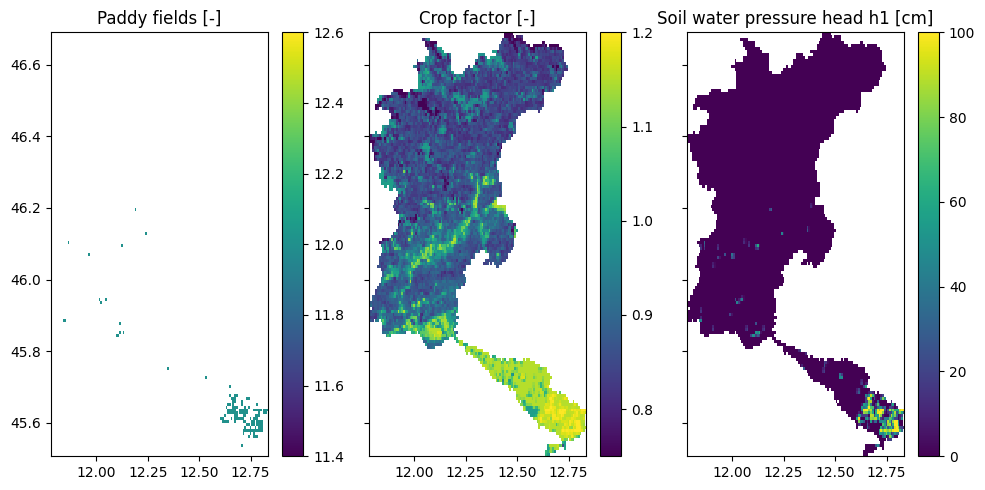

In [5]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 5))

axes[0].set_title("Paddy fields [-]")
axes[1].set_title("Crop factor [-]")
axes[2].set_title("Soil water pressure head h1 [cm]")

rice = mod.grid["wflow_landuse"].where(
    mod.grid["wflow_landuse"] == 12, mod.grid["wflow_landuse"].raster.nodata
)
rice.raster.mask_nodata().plot(ax=axes[0], add_labels=False)
mod.grid["kc"].raster.mask_nodata().plot(ax=axes[1], add_labels=False)
mod.grid["h1"].raster.mask_nodata().plot(ax=axes[2], add_labels=False)

fig.tight_layout()

A `kvfrac` map is added that adds a layer with very low vertical hydraulic conductivity in the cells with paddy irrigation. The target conductivity value can be set for each layer using the `target_conductivity` parameter, and sets a value for each layer in the wflow model (linked to the `wflow_thicknesslayer` parameter). See the figures below for an indication of these maps and their effect on the vertical conductivity.

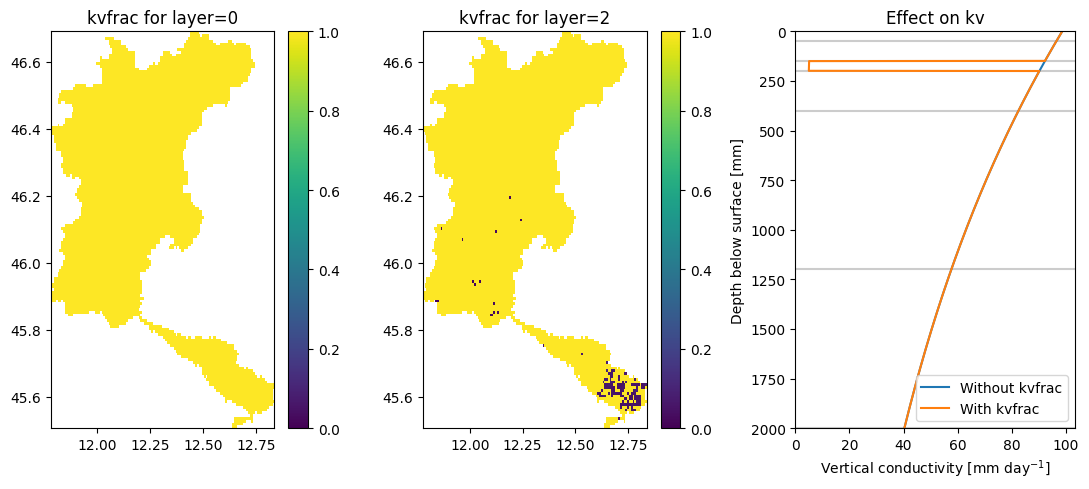

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(11, 5))

ax1, ax2, ax3 = axes.flatten()

ax1.set_title("kvfrac for layer=0")
ax2.set_title("kvfrac for layer=2")
ax3.set_title("Effect on kv")

mod.grid["kvfrac"].sel(layer=0).raster.mask_nodata().plot(
    ax=ax1, add_labels=False, vmin=0, vmax=1
)
mod.grid["kvfrac"].sel(layer=2).raster.mask_nodata().plot(
    ax=ax2, add_labels=False, vmin=0, vmax=1
)

# Take the cumulative sum to get to the cumulative layers
layers = np.cumsum(mod.get_config("model.thicknesslayers"))
layers = np.append(layers, 2000)
# Add layers to figure
for layer in layers:
    ax3.axhline(y=layer, c="0.8")

# Position of a paddy pixel
lat = 45.63
lon = 12.66

# Read required layers
kv_0 = mod.grid["KsatVer"].sel(latitude=lat, longitude=lon, method="nearest")
kvfrac = mod.grid["kvfrac"].sel(latitude=lat, longitude=lon, method="nearest")
f = mod.grid["f"].sel(latitude=lat, longitude=lon, method="nearest")

# Compute original kv values (without kvfrac)
depths = np.arange(0, 2000)
original = kv_0.values * np.exp(-f.values * depths)

# Compute new kv values
corrected = original.copy()
idxs = np.where(kvfrac.values != 1)[0]
for idx in idxs:
    start_depth = layers[idx - 1]
    end_depth = layers[idx]
    corrected[start_depth:end_depth] *= kvfrac.values[idx]

ax3.plot(original, depths, label="Without kvfrac")
ax3.plot(corrected, depths, label="With kvfrac")

# Flip y-axis for easier understanding of depth profile
ax3.set_ylim(2000, 0)
ax3.set_xlim(0, ax3.get_xlim()[1])
ax3.set_xlabel("Vertical conductivity [mm day$^{-1}$]")
ax3.set_ylabel("Depth below surface [mm]")
ax3.legend(loc="lower right")

fig.tight_layout()

#### Industry, livestock and domestic demand

For the non_irrigation related demand, we assume those to be already prepared datasets with gross and net (consumption) demands. In this example, we rely on data from the PCR-GLOBWB model. See the images below for an explanation of the data and added layers to the wflow model configuration.

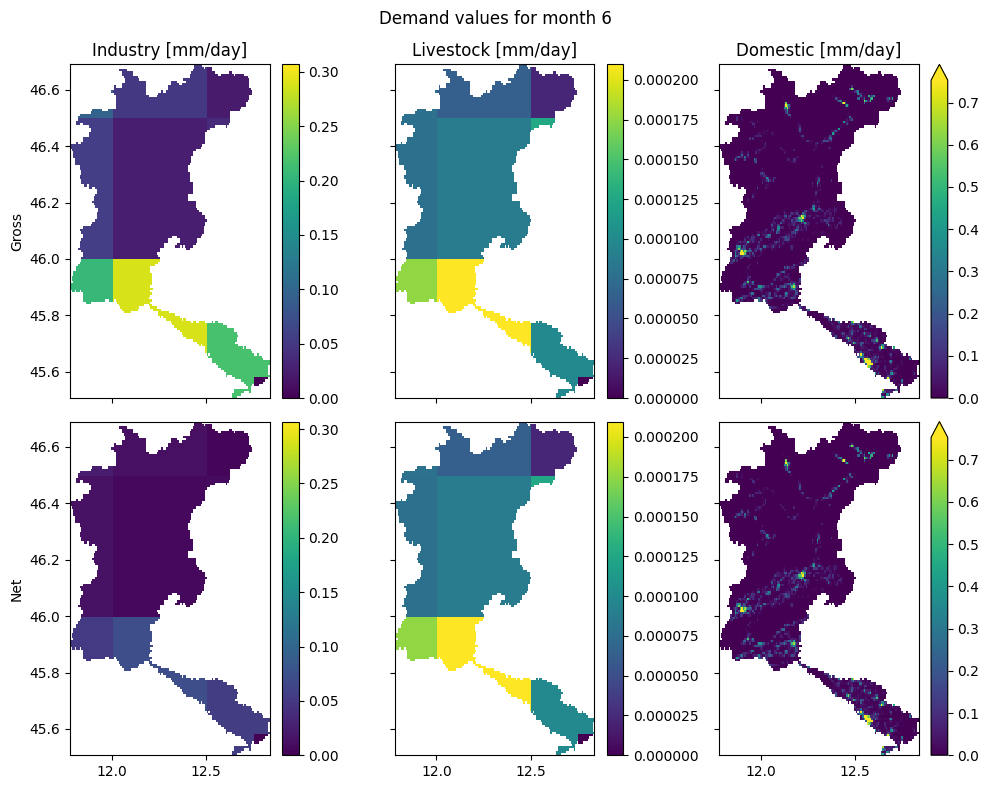

In [7]:
month = 6

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 8))

fig.suptitle(f"Demand values for month {month}")

axes[0][0].set_title("Industry [mm/day]")
axes[0][1].set_title("Livestock [mm/day]")
axes[0][2].set_title("Domestic [mm/day]")
axes[0][0].set_ylabel("Gross")
axes[1][0].set_ylabel("Net")

# Extracting the min-max ranges for consistent colorbars
ind_min = mod.grid["industry_gross"].min()
ind_max = mod.grid["industry_gross"].max()
lsk_min = mod.grid["livestock_gross"].min()
lsk_max = mod.grid["livestock_gross"].max()
dom_min = mod.grid["domestic_gross"].min()
dom_max = mod.grid["domestic_gross"].max()

# Plot industry
mod.grid["industry_gross"].sel(time=month).plot(
    ax=axes[0][0], add_labels=False, vmin=ind_min, vmax=ind_max
)
mod.grid["industry_net"].sel(time=month).plot(
    ax=axes[1][0], add_labels=False, vmin=ind_min, vmax=ind_max
)
# Plot livestock
mod.grid["livestock_gross"].sel(time=month).plot(
    ax=axes[0][1], add_labels=False, vmin=lsk_min, vmax=lsk_max
)
mod.grid["livestock_net"].sel(time=month).plot(
    ax=axes[1][1], add_labels=False, vmin=lsk_min, vmax=lsk_max
)
# Plot domestic (adjusted the max range to improve plotting)
mod.grid["domestic_net"].sel(time=month).plot(
    ax=axes[0][2], add_labels=False, vmin=dom_min, vmax=dom_max * 0.3
)
mod.grid["domestic_net"].sel(time=month).plot(
    ax=axes[1][2], add_labels=False, vmin=dom_min, vmax=dom_max * 0.3
)


fig.tight_layout()

In the figure above, we see a slight difference between the gross and net demand for the industry sector. This means that this sector consumes part of the demanded water, but returns a portion of the water back. On the other hand, the gross and net demands for both livestock and domestic are roughly the same, meaning that the majority of the water will be consumed.

For the industry and livestock sectors, we see the relatively low-resolution of the original data. This data is retrieved from the PCR-GLOBWB model, which was provided at a resolution of 0.5x0.5 degrees (roughly 40x40km). The same holds for the domestic demands data, but it was downscaled using population density in the `setup_non_irrigation` workflow (using the dataset provided in `population_fn`, which is an optional step). The population data is used to identify densely populated regions, and downscales this to the cities/villages where the people actually live. To give an impression, see the figure below for an insight into the population data. Please note that this is the data at the original resolution of ~100x100m. The data at the wflow model resolution is provided in the staticmaps (see `mod.grid["Population_scaled"]`).


<Axes: >

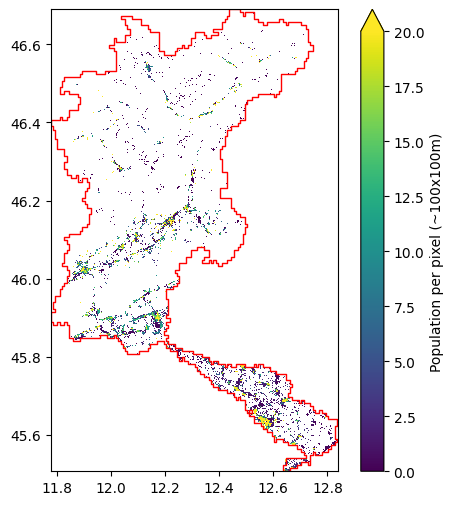

In [8]:
# Read original data and slice to model domain
pop_ds = mod.data_catalog.get_rasterdataset(
    "worldpop_2020_constrained", geom=mod.geoms["basins"]
)
# Get mask of catchment
pop_ds_mask = pop_ds.raster.geometry_mask(mod.geoms["basins"])
pop_ds = pop_ds.raster.mask_nodata().where(pop_ds_mask)

# Plot data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# Add original population data to figure
pop_ds.plot(
    ax=ax,
    vmax=20,
    add_labels=False,
    cbar_kwargs={"label": "Population per pixel (~100x100m)"},
)
# Add basin geometry to plot
mod.geoms["basins"].plot(ax=ax, facecolor="none", edgecolor="red")

#### Irrigation maps

For the `setup_irrigation` workflow, a number of maps have been added to the model:
- **paddy_irrigation_areas**: mask (0/1) of the cells that are considered to be paddy/rice fields
- **nonpaddy_irrigation_areas**: mask (0/1) of the cells that are irrigated, but not paddy/rice fields
- **nonpaddy_irrigation_trigger**: trigger (0/1) that indicates whether we expect irrigation to occur (based on the LAI, to identify the growing season)
- **paddy_irrigation_trigger**: trigger (0/1) that indicates whether we expect irrigation to occur on paddies (based on the LAI, to identify the growing season)

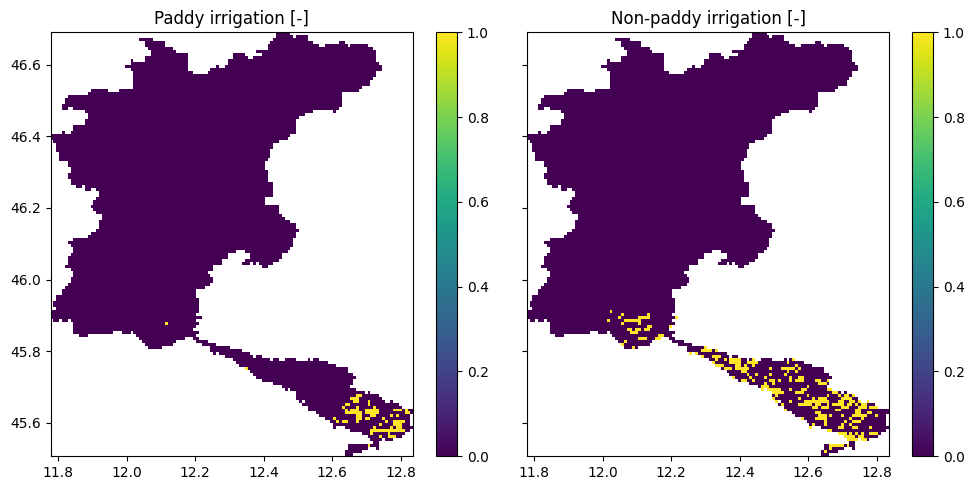

In [9]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

axes[0].set_title("Paddy irrigation [-]")
axes[1].set_title("Non-paddy irrigation [-]")

mod.grid["paddy_irrigation_areas"].raster.mask_nodata().plot(
    ax=axes[0], add_labels=False
)
mod.grid["nonpaddy_irrigation_areas"].raster.mask_nodata().plot(
    ax=axes[1], add_labels=False
)

fig.tight_layout()

In this figure, we see the cells with paddy (rice fields) and non-paddy irrigated areas. Cells are identified as such when they exceed a fractional threshold of the cell (set by `area_threshold`). A cell can only be either paddy-irrigated, non-paddy-irrigated, or rain-fed. In the third panel, we see the crop factor associated for all of the model pixels.

In the figures below, we show the irrigation trigger maps for three months: before the growing season, during the growing season, and in the closing stages of the growing season. A map with a mask (0/1) contains information whether irrigation is allowed to occur during this month.

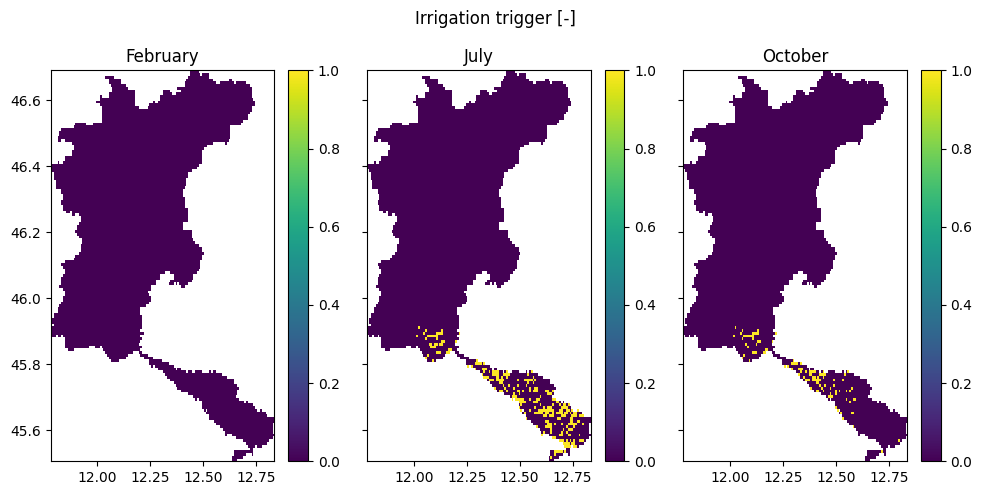

In [10]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 5))

fig.suptitle("Irrigation trigger [-]")

axes[0].set_title("February")
axes[1].set_title("July")
axes[2].set_title("October")

mod.grid["nonpaddy_irrigation_trigger"].sel(time=2).raster.mask_nodata().plot(
    ax=axes[0], add_labels=False, vmin=0, vmax=1
)
mod.grid["nonpaddy_irrigation_trigger"].sel(time=7).raster.mask_nodata().plot(
    ax=axes[1], add_labels=False, vmin=0, vmax=1
)
mod.grid["nonpaddy_irrigation_trigger"].sel(time=10).raster.mask_nodata().plot(
    ax=axes[2], add_labels=False, vmin=0, vmax=1
)

fig.tight_layout()

#### Water allocation regions

To define regions where water can be shared and allocated, a merge between catchment and water areas or administrative boundaries is computed. These result in regions where wflow can allocate available water. No water allocation is supported between these regions. To give an impression on how these regions look like, see the following figures for an example.

Note: Water areas or regions are generally defined by sub-river-basins within a Country. In order to mimick reality, it is advisable to avoid cross-Country-border abstractions. Whenever information is available, it is strongly recommended to align the water regions with the actual areas managed by water management authorities, such as regional water boards.

<Axes: title={'center': 'Allocation areas'}>

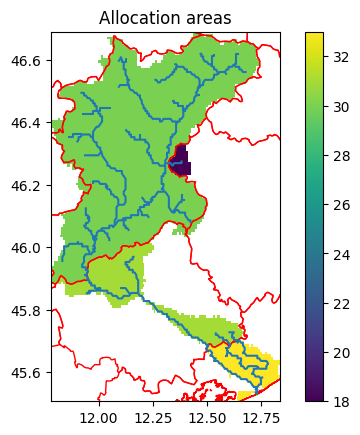

In [11]:
# Read original data and slice to model domain
admin = mod.data_catalog.get_geodataframe("gadm_level2", geom=mod.geoms["basins"])

fig, ax = plt.subplots(1)

ax.set_title("Allocation areas")

mod.grid["allocation_areas"].raster.mask_nodata().plot(ax=ax, add_labels=False)
admin.plot(ax=ax, facecolor="none", edgecolor="red")
mod.geoms["rivers"].plot(ax=ax)

When merging the wflow basins with the water regions, some small subbasins can be created that do not contain river cells. These small basins will be merged to larger basins. When merging, you can decide if you prefer to merge with the nearest downstream basin, or with any basin in the same water region that does contain river using the ``priotity_basins`` argument. In the previous map, we gave priority to the basins, here is the results if priority is given to water regions instead:

<Axes: title={'center': 'Allocation areas'}>

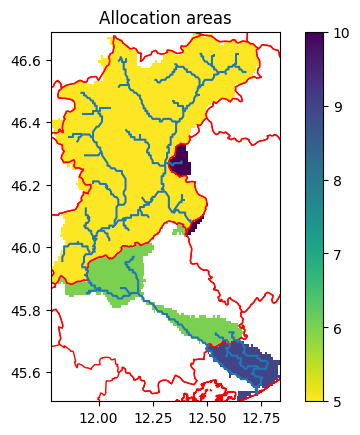

In [12]:
# Create allocations areas
mod.setup_allocation_areas(
    waterareas_fn="gadm_level2",
    priority_basins=False,
)

fig, ax = plt.subplots(1)

ax.set_title("Allocation areas")

mod.grid["allocation_areas"].raster.mask_nodata().plot(
    ax=ax, add_labels=False, cmap="viridis_r"
)
admin.plot(ax=ax, facecolor="none", edgecolor="red")
mod.geoms["rivers"].plot(ax=ax)

Here we see a couple of distinct administrative boundaries (black lines), some of which already follow the catchment boundaries. When the catchment crosses an administrative boundary, that region receives a different but unique identifier. Note that we are using level 2 boundaries here, which might not be the most realistic for a region of this size.

#### Surface water frac used for water allocation

By default, Wflow will allocate all water demands with water from the surface water (frac_sw_used=1). However, if in a certain areas, groundwater or other non conventional sources can be used, the frac_sw_used of each allocation area can be reduced and prepared using the **setup_allocation_surfacewaterfrac** method.

Here we used global data from GLOFAS (Lisflood) for the fraction of grounwater used, presence of groundwater bodies and non conventional sources (0 is Piave). The water allocations are the ones we prepared in the previous step in order to match better the wflow model basin delineation.

Let's have a look at the resulting map:

<Axes: title={'center': 'Allocation surface water frac used'}>

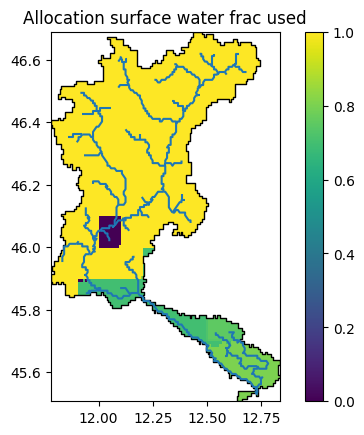

In [13]:
fig, ax = plt.subplots(1)

ax.set_title("Allocation surface water frac used")

mod.grid["frac_sw_used"].raster.mask_nodata().plot(ax=ax, add_labels=False)
mod.geoms["basins"].plot(ax=ax, facecolor="none", edgecolor="black")
mod.geoms["rivers"].plot(ax=ax)